In [11]:
#scientific libraries and plotting
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import awkward as ak

#torch specific
import torch
import torchvision as torchv
import torch.optim as optim

#other libraries
import time
import sys
from pathlib import Path
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import atlas_mpl_style as ampl
#Using newest versions of all libraries

In [12]:
# import custom functions from src folder
module_path = str(Path.cwd().parents[0] / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

from machine_learning import *
from resnet import *
from imcal import *

from resnet import ResNet18

In [13]:
#variables controlled by the user. Change these to fit your specific needs.
RES = 50 #resolution
"""
#Data specification
LABELS = ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", "BH_n2_M10", "BH_n4_M10", "BH_n6_M10"] #for plotting #"PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", 
TEST_LABELS = [f"{label}_test" for label in LABELS]
PLOT_LABELS = ["SPH_9TEV", "BH_n2_M10", "BH_n4_M10", "BH_n6_M10"]
CLASSES = len(LABELS) #The number of output nodes in the net, equal to the number of classes
FOLDERS = ["sph", "BH", "BH", "BH"]
"""

LABELS = ["PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL", "BH_n4_M10"]
TEST_LABELS = [f"{label}_test" for label in LABELS]
PLOT_LABELS = ["SPH_9TeV", "BH_n4_M10"]
CLASSES = 2 #The number of output nodes in the net, equal to the number of classes
FOLDERS = ["sph", "BH"]
#TEST_FILENAMES = [f"{label}_res{RES}_STmin7_Nmin5_3000_events.h5" for label in TEST_LABELS]
#TEST_FILENAMES = [f"{label}_res{RES}_3000_events.h5" for label in TEST_LABELS]
N_EVENTS = [3000, 3000]
TEST_N_EVENTS = 3000
CUT=False

#Set data paths
if CUT:
    TEST_FILENAMES = [f"{label}_res{RES}_STmin7_Nmin5_{n}_events.h5" for label, n in zip(TEST_LABELS, N_EVENTS)]
else:
    TEST_FILENAMES = [f"{label}_res{RES}_{n}_events.h5" for label, n in zip(TEST_LABELS, N_EVENTS)]

TEST_DATAPATHS = [f"/disk/atlas3/data_MC/2dhistograms/{FOLDERS[i]}/{RES}/{TEST_FILENAMES[i]}" for i in range(len(LABELS))] #The path to the folder containing the testing histogram files

#MODEL_NAME = "resnet_1675340381_SPH_9TeV_BH_n4_M10"
MODEL_NAME = "resnet_1675347192_SPH_9TeV_BH_n4_M10_CUT"
LOAD_FOLDER = "/home/agrefsru/imcalML/results/models"
LOAD_PATH = f"{LOAD_FOLDER}/{MODEL_NAME}.pt"

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    torch.cuda.empty_cache()
    print("Running on the GPU")
else:
    DEVICE = torch.device("cpu")
    print("Running on the CPU")
ampl.use_atlas_style() 

Running on the GPU


In [14]:
#Load model
model = ResNet18(img_channels=3, num_classes=CLASSES)
model.load_state_dict(torch.load(LOAD_PATH))
model.eval()
model.to(DEVICE)
print("Loading model")

Loading model


In [15]:
#Load data
testpaths = [Path(path) for path in TEST_DATAPATHS]
print(testpaths)

test_data = Hdf5Dataset(testpaths, TEST_LABELS, DEVICE, shuffle=False, filters=None, transform=None, event_limit=TEST_N_EVENTS)
eventids = test_data.getids().flatten()
if len(eventids) != len(test_data):
    print("Error in lengths of arrays")

[PosixPath('/disk/atlas3/data_MC/2dhistograms/sph/50/PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_test_res50_3000_events.h5'), PosixPath('/disk/atlas3/data_MC/2dhistograms/BH/50/BH_n4_M10_test_res50_3000_events.h5')]


In [16]:
print(eventids[0:20])

[   1    2   11  101 1001 1002 1003 1004 1005 1006 1007 1008 1009 1010
  102 1011 1012 1013 1014 1015]


In [17]:
truth, preds = predict(model, test_data, CLASSES, 1, RES, DEVICE)
df = pd.DataFrame(dict(zip(["Truth", "Prediction"], [truth, preds])))
df["EventID"] = eventids
accuracy = accuracy_score(truth, preds, normalize=True)

100%|██████████| 6000/6000 [00:42<00:00, 140.79it/s]


[93.9, 6.1, 14.67, 85.33]


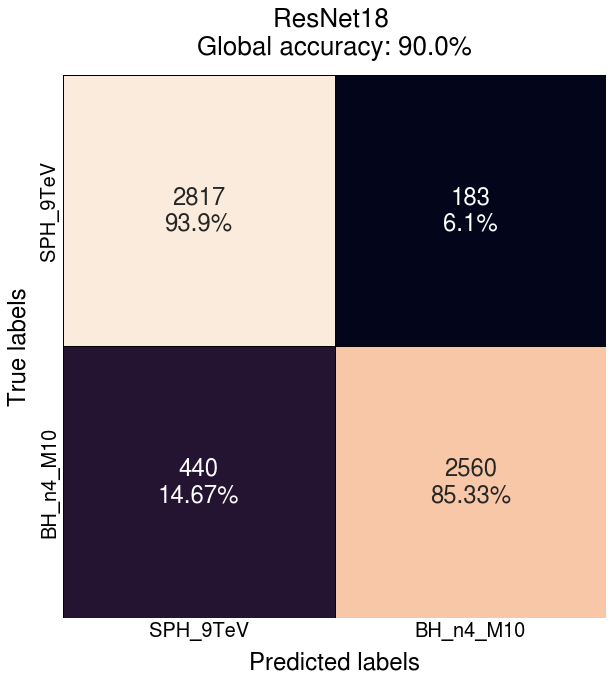

In [18]:
def plot_conf_matrix(confusion, accuracy, labels):
    """
    plot confusion matrix
    """
    fig, ax = plt.subplots(1,1, figsize=(10,10))

    #Generate the confusion matrix
    cf_matrix = confusion_matrix(confusion["Truth"], confusion["Prediction"])
    cf_matrix = np.round(cf_matrix, 3)
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    sum_rows = [sum(row) for row in cf_matrix]
    group_percentages = np.array([values/row for row, values in zip(sum_rows, cf_matrix)])
    group_percentages = [round(100*value, 2) for value in group_percentages.flatten()]
    print(group_percentages)
    annot =  [f"{v1}\n{v2}%" for v1, v2 in zip(group_counts, group_percentages)]
    annot = np.asarray(annot).reshape(len(labels),len(labels))
    sn.heatmap(
            cf_matrix, 
            ax=ax, 
            annot=annot, 
            cmap='rocket', 
            linewidths=1.0, 
            linecolor='black',
            cbar = False, 
            square=True, 
            fmt='', 
            cbar_kws={'format':'%.0f'},
            annot_kws={"size": 24}
        )

    #ax.set_title('Confusion matrix\n\n', size=24)
    ax.set_xlabel('Predicted labels', size=24, labelpad= 10)
    ax.set_ylabel('True labels', size=24, labelpad = 10)

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(labels, size=20)
    ax.yaxis.set_ticklabels(labels, size=20)
    ax.tick_params(which="both", left=False, bottom=False, top=False, right=False)
    ax.set_title(f"ResNet18 \nGlobal accuracy: {round(accuracy, 2)*100}%", size=26, pad=20)

    ## Display the visualization of the Confusion Matrix.
    plt.show()
plot_conf_matrix(df, accuracy, PLOT_LABELS)

In [19]:
df_wrong = df[df["Prediction"] != df["Truth"]]

In [20]:
def save_wrong_predictions(truths, labels, eventids, savepath, filename):
    file = open(f"{savepath}/{filename}.csv", "w")
    file.write(f"Wrongly predicted events from datasets: {testpaths} by model {MODEL_NAME}")
    for i, truth in enumerate(truths):
        file.write(f"{labels[int(truth)]}, {eventids[i]}\n")
    file.close()
    
filename = f"{MODEL_NAME}_wrongly_predicted"
save_wrong_predictions(df_wrong["Truth"].tolist(), PLOT_LABELS, df_wrong["EventID"].tolist(), "../results/", filename)